In [60]:
from drift_agrawal import SubgroupDriftAgrawal
import numpy as np

In [140]:
train_size = 10_000
batch_size = 1000
test_batches=200

ds = SubgroupDriftAgrawal(sg_size=0.01,
                          perturbation=0.01,
                          position=train_size + (test_batches // 2) * batch_size,
                          width = (test_batches // 4) * batch_size)

In [141]:
def to_Xy(ds, n : int = 10_000, drift_info : bool = False):
    X = []
    y = []
    sg_list = []
    drifted_list = []
    for vals in ds.take(n, drift_info=drift_info):
        if drift_info:
            x_val, y_val, sg, drifted = vals
        else:
            x_val, y_val = vals
        X.append(list(x_val.values()))
        y.append(y_val)
        if drift_info:
            sg_list.append(sg)
            drifted_list.append(drifted)
    
    if drift_info:
        return np.array(X), np.array(y), np.array(sg_list), np.array(drifted_list)
    return np.array(X), np.array(y)

In [142]:
X_train, y_train = to_Xy(ds, 10_000)

In [143]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from river.drift import binary as drift

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)

detector = drift.DDM(warm_start=1000)
# detector = ADWIN(delta=1e-2)
acc = []
acc_sg = []
det = []
for batch in range(test_batches):
    X_test, y_test, is_sg, _ = to_Xy(ds, 1_000, drift_info=True)
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    if sum(is_sg) > 0:
        acc_sg.append(accuracy_score(y_test[is_sg], y_pred[is_sg]))
    else:
        acc_sg.append(0)

    c = 0
    for p in y_test != y_pred:
        detector.update(p)
        c += detector.drift_detected
    
    if c > 0:
        print(c)
    det.append(c)
    

1
1
1
1
1
1
1


In [144]:
import matplotlib.pyplot as plt

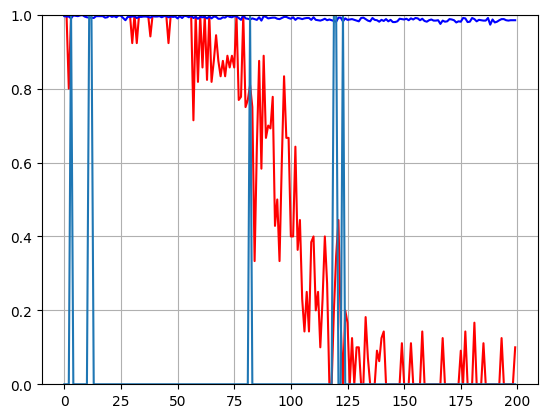

In [145]:
plt.plot(acc_sg, c='r')
plt.plot(acc, c='b')
plt.grid()
plt.ylim([0, 1])

det = np.array(det)
det = det / det.max()
plt.plot(det)